In [1]:
!gdown --id 1fHIY7QNnmxpZpEgf-IgacQ-rPxsq2_yb -O deep_sort.tar
import tarfile
with tarfile.open('deep_sort.tar', 'r') as tar:
    tar.extractall()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fHIY7QNnmxpZpEgf-IgacQ-rPxsq2_yb
To: /content/deep_sort.tar
100% 1.06G/1.06G [00:24<00:00, 43.4MB/s]


- `detector_models`: contains the weights for the object detector models.

- `outputs`: Stores the output videos generated by the tracking system.

- `reid_models`: Contains the weights for the re-identification (ReID) models.

- `sample`: This directory contains five sample videos.

In [ ]:
import argparse
import sys
from pathlib import Path
import torch
import torch.backends.cudnn as cudnn
import os
import cv2
from pathlib import Path
import tensorflow as tf
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import warnings
import time
from PIL import Image
warnings.filterwarnings('ignore')

!pip install scikit-learn==0.22.2.post1 --upgrade #fix linear_assignment.py error
!pip install motmetrics

%cd ./deep_sort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.22.2.post1-cp310-cp310-linux_x86_64.whl size=23209524 sha256=5c6333ba70287ea58ec5493f717565ecf4aed3bf5c5e9235c842473f2a8ceaed
  Stored in directory: /root/.cache/pip/wheels/ce/2c/b8/7c122186e1eaa3d04170e9eb4ad410115e7e593a57d2366e4c
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.10.1 requires scikit-learn>=1.0.2, but you have scikit-learn 0.22.2.post1 which is incompatible.
mlxtend 0.22.0 requires scikit-learn>=1.0.2, but you have scikit-learn 0.22.2.post1 which 

In [ ]:
!ls

application_util  detector_models	    README.md	     tools
deep-person-reid  evaluate_motchallenge.py  reid_models      TrackEval
deep_sort2	  generate_videos.py	    sample	     yolov5
deep_sort_app.py  outputs		    show_results.py


In [ ]:
#YOLO
#!git clone https://github.com/ultralytics/yolov5.git

%cd ./yolov5
!pip install -r requirements.txt


%cd ../../deep_sort
cwd = os.getcwd()
sys.path.append(os.path.join(cwd, 'yolov5'))

import torch
from yolov5.models.experimental import attempt_load
from yolov5.utils.dataloaders import LoadImages
from yolov5.utils.general import non_max_suppression, scale_boxes
from yolov5.utils.torch_utils import select_device

/content/deep_sort/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.9/603.9 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
/content/deep_sort


In [ ]:
#Import original DeepSort files

#!git clone https://github.com/nwojke/deep_sort.git #import rep
cwd = os.getcwd()
new_dir = os.path.join(cwd, 'deep_sort3')
sys.path.append(os.path.join(cwd, 'deep_sort3')) #bcs

from deep_sort3 import nn_matching
from deep_sort3.detection import Detection
from deep_sort3.tracker import Tracker
from tools import generate_detections as gdet_3
from deep_sort3.detection import Detection as ddet
from application_util import preprocessing

In [ ]:
#TORCH-REID
#!git clone https://github.com/KaiyangZhou/deep-person-reid.git

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, 'deep-person-reid'))

import torch
import torchreid
torchreid.models.show_avai_models()
from torchreid.utils import FeatureExtractor

['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'resnet50_fc512', 'se_resnet50', 'se_resnet50_fc512', 'se_resnet101', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'densenet121_fc512', 'inceptionresnetv2', 'inceptionv4', 'xception', 'resnet50_ibn_a', 'resnet50_ibn_b', 'nasnsetmobile', 'mobilenetv2_x1_0', 'mobilenetv2_x1_4', 'shufflenet', 'squeezenet1_0', 'squeezenet1_0_fc512', 'squeezenet1_1', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'mudeep', 'resnet50mid', 'hacnn', 'pcb_p6', 'pcb_p4', 'mlfn', 'osnet_x1_0', 'osnet_x0_75', 'osnet_x0_5', 'osnet_x0_25', 'osnet_ibn_x1_0', 'osnet_ain_x1_0', 'osnet_ain_x0_75', 'osnet_ain_x0_5', 'osnet_ain_x0_25']


This is to calculate precision/recall for detectors

In [ ]:
def iou(box1, box2):
  x1, y1, w1, h1, *_ = box1
  x2, y2, w2, h2, *_ = box2
  w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
  h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
  if w_I <= 0 or h_I <= 0:  # no overlap
      return 0
  I = w_I * h_I
  U = w1 * h1 + w2 * h2 - I
  return I / U

from scipy.optimize import linear_sum_assignment
def calculate_precision_recall(gt_boxes, detection_boxes):
  precisions = []
  recalls = []
  N = len(detection_boxes)
  for frame_idx in range(N):
      gt_boxes_f = gt_boxes[frame_idx]
      det_boxes_f = detection_boxes[frame_idx]
      ious = np.array([[iou(gt_box, det_box) for det_box in det_boxes_f] for gt_box in gt_boxes_f])
      cost_matrix = 1 - ious
      row_indices, col_indices = linear_sum_assignment(cost_matrix)
      tp = len([1 for i, j in zip(row_indices, col_indices) if ious[i, j] > 0.5])
      fp = len(det_boxes_f) - tp
      fn = len(gt_boxes_f) - tp
      precisions.append(tp / (tp + fp) if tp + fp > 0 else 0)
      recalls.append(tp / (tp + fn) if tp + fn > 0 else 0)
  precision = np.mean(precisions)
  recall = np.mean(recalls)
  print(f"Precision: {precision}, Recall: {recall}")

# GROUND TRUTH
def get_gt_data(file_path):
  gt_data = pd.read_csv(file_path, sep=",", header=None, usecols=range(6))
  gt_data.columns = ['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height']
  N = gt_data['frame'].max()
  gt_tracks = []
  gt_boxes = []

  for i in range(1, N+1):
      current_frame_data = gt_data[gt_data['frame'] == i].copy()
      gt_tracks.append(current_frame_data['id'].tolist())
      current_frame_data['bb_right'] = current_frame_data['bb_left'] + current_frame_data['bb_width']
      current_frame_data['bb_bottom'] = current_frame_data['bb_top'] + current_frame_data['bb_height']
      gt_boxes.append(current_frame_data[['bb_left', 'bb_top', 'bb_right', 'bb_bottom']].values.tolist())
  return gt_boxes, gt_tracks

In [ ]:
class ModifiedDeepSort:
    def __init__(self,
                 device='cuda',
                 detector_weights='./detector/yolov5x.pt',
                 encoder_model_name=None,
                 encoder_model_path=None,
                 conf_threshold = 0.25,
                 iou_threshold = 0.45,
                 max_cosine_distance = 0.3,
                 nms_max_overlap = 1.0
                 ):
        self._device = device
        self._max_cosine_distance = max_cosine_distance
        self._nms_max_overlap = nms_max_overlap
        nn_budget = None
        metric = nn_matching.NearestNeighborDistanceMetric("cosine", self._max_cosine_distance, nn_budget)
        self._tracker = Tracker(metric)
        self._detector_model = self.load_detector_model(detector_weights)
        self._encoder = self.load_encoder_model(encoder_model_name, encoder_model_path)
        self._conf_threshold = conf_threshold
        self._iou_threshold = iou_threshold

    def reset_tracker(self):
        metric = nn_matching.NearestNeighborDistanceMetric("cosine", self._max_cosine_distance, None)
        self._tracker = Tracker(metric)

    def load_detector_model(self, detector_weights):
        try:
            detector_model = self.load_model(detector_weights, self._device)
            #self.stride, self.names = self.detector_model.stride, self.detector_model.names
        except Exception as e:
            print(f"Error loading detector model with weights {detector_weights}: {e}")
        return detector_model

    def load_encoder_model(self, encoder_model_name=None, encoder_model_path=None):
        encoder = None
        try:
            if encoder_model_name is None:
                encoder = gdet_3.create_box_encoder('./reid_models/mars-small128.pb', batch_size=1)

            else:
                encoder = FeatureExtractor(
                    model_name=encoder_model_name,
                    model_path=encoder_model_path,
                    device='cuda'
                )
        except Exception as e:
            print(f"Error loading encoder model {encoder_model_name} with path {encoder_model_path}: {e}")
        return encoder

    def load_model(self, weights, device):
        return attempt_load(weights, device)

    def get_detections_from_model(self, frames, detector_img_size):
        img0_shapes = [frame.shape for frame in frames]
        resized_frames = [Image.fromarray(frame).resize(detector_img_size, Image.ANTIALIAS) for frame in frames]
        resized_frames = [np.array(img) for img in resized_frames]
        img1_shapes = [frame.shape for frame in resized_frames]
        imgs = [frame.transpose((2, 0, 1)) for frame in resized_frames]
        imgs = [torch.from_numpy(img).to(self._device).float() / 255.0 for img in imgs]
        imgs = torch.stack(imgs)

        pred = self._detector_model(imgs)[0]
        classes =[0,]
        pred = non_max_suppression(pred, self._conf_threshold, self._iou_threshold, classes=classes, agnostic=False)
        batch_detections = []
        for b in range(len(pred)):
            detections = []
            det = pred[b]
            if det is not None and len(det):
                det[:, :4] = scale_boxes(img1_shapes[b], det[:, :4], img0_shapes[b]).round()
                for *xyxy, conf, cls in reversed(det):
                    x1, y1, x2, y2 = xyxy
                    detections.append((int(x1), int(y1), int(x2), int(y2), float(conf)))
            batch_detections.append(detections)

        return batch_detections

    def extract_features(self, frame, detections):
        boxes = np.array([bbox[:4] for bbox in detections])
        scores = np.array([d[4] for d in detections])
        if type(self._encoder)== FeatureExtractor:
          patches = [frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2]), :] for bbox in boxes]
          patches = [cv2.resize(patch, (128, 256)) for patch in patches]
          patches = [torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float().div(255.).to(self._device) for patch in patches]
          features = [self._encoder(patch).squeeze().cpu().numpy() for patch in patches]
          boxes[:, 2] = boxes[:, 2] - boxes[:, 0]  # w = x1 - x
          boxes[:, 3] = boxes[:, 3] - boxes[:, 1]  # h = y1 - y
        else:
          boxes[:, 2] = boxes[:, 2] - boxes[:, 0]  # w = x1 - x
          boxes[:, 3] = boxes[:, 3] - boxes[:, 1]  # h = y1 - y
          features = self._encoder(frame, boxes )
        detections = [Detection(bbox, score, feature) for bbox, score, feature in zip(boxes, scores, features)]
        return detections

    def load_model(self, weights, device):
        return attempt_load(weights, device)

    def get_detections_and_track2(self, video_path,
                             sort=True,
                             save_result = True):

        cap = cv2.VideoCapture(str(video_path))
        outp = None
        self.reset_tracker()
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fps_original = cap.get(cv2.CAP_PROP_FPS)
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        if save_result:
          basename = os.path.basename(video_path)
          name, ext = os.path.splitext(basename)
          video_output_path = os.path.join("./outputs", f'{name}_output_det1.avi')
          outp = cv2.VideoWriter(video_output_path, fourcc,fps_original, (frame_width, frame_height))

        frame_index = 0
        detection_boxes = []
        frames = []
        tracker_results = []
        start_time = time.time()  # Record start time

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
            detections = self.get_detections_from_model(frames, (frame_width//64 * 64, frame_height//64 * 64))[0] #processes a batch, but it's one frame here
            min_area = 10
            detections = [bbox for bbox in detections if (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) > min_area]
            if len(detections)>0:
              if sort:
                detections = self.extract_features(frame, detections)

                # TRACKER
                self._tracker.predict()

                self._tracker.update(detections)
                detection_frame = []
                for track in self._tracker.tracks:
                    if not track.is_confirmed() or track.time_since_update > 1:
                        continue
                    bbox = track.to_tlbr()  # top-left and bottom-right corners
                    detection_frame.append(bbox)
                    tracker_results.append([frame_index, track.track_id, bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1], 1, -1, -1, -1])
                    if save_result:
                      cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 2)
                      cv2.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])),0, 5e-3 * 200, (0,255,0),2)

                detection_boxes.append(detection_frame)
              else:
                detection_boxes.append(detections)
                if save_result:
                  for bbox in detections:
                    cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 2)
            frames = []
            frame_index += 1
            #if frame_index % 50 == 0:
            #  print(frame_index)
            if save_result:
              outp.write(frame)
        end_time = time.time()
        total_time = end_time - start_time
        fps = frame_index / total_time

        print("FPS: ", fps)
        if save_result:
          outp.release()
        cap.release()
        tracker_results = np.array(tracker_results).astype(int)
        return detection_boxes, tracker_results, fps


Func to run deep sort through all the videos

In [ ]:
def run_evaluation(yolo_model, reid_model, reid_model_path, conf_threshold, iou_threshold, max_cosine_distance, nms_max_overlap):
    video_files = {
       "PETS09-S2L1-raw": "PETS09-S2L1", #768x576
        "KITTI-17-raw": "KITTI-17", #1224x370
        "MOT16-09-raw": "MOT16-09", #1920x1080
        "MOT16-11-raw": "MOT16-11", #1920x1080
        "TUD-Campus-raw": "TUD-Campus", #640x480
        "TUD-Stadtmitte-raw": "TUD-Stadtmitte", #640x480
    }

    device = select_device('0' if torch.cuda.is_available() else 'cpu')

    hota_scores = []  # A list to hold the HOTA scores for each video
    results = []

    mds = ModifiedDeepSort(
            device= device,
            detector_weights=f'./detector/{yolo_model}.pt',
            conf_threshold = conf_threshold,
            iou_threshold = iou_threshold,
            max_cosine_distance = max_cosine_distance,
            nms_max_overlap = nms_max_overlap,
            encoder_model_name = reid_model,
            encoder_model_path = reid_model_path,
        )

    for video_raw, video in video_files.items():
        print(video)

        video_file_path = Path(f"./sample/{video_raw}.webm")

        video_folder = "MOT15"
        if video == "MOT16-09" or video == "MOT16-11":
            video_folder = "MOT16"

        ## Uncomment to calculate fps/accuracy for detections alone.
        #detection_boxes, _, _ = mds.get_detections_and_track2(video_file_path, sort=False, save_result=False)
        #if ("KITTI-17" in video_raw) or ("MOT16" in video_raw):
        #    detection_boxes = [[(bbox[0]*2, bbox[1]*2, bbox[2]*2, bbox[3]*2, bbox[4]) for bbox in frame] for frame in detection_boxes]

        #file_txt = f"./TrackEval/data/gt/mot_challenge/{video_folder}-train/{video}/gt/gt.txt"
        #gt_boxes, gt_tracks = get_gt_data(file_txt)

        #calculate_precision_recall(gt_boxes, detection_boxes)

        _, tracker_results, fps = mds.get_detections_and_track2(video_file_path, sort=True, save_result=True)
        if ("KITTI-17" in video_raw) or ("MOT16" in video_raw):
            tracker_results[:, 1:5] *= 2

        path = f'TrackEval/data/trackers/mot_challenge/{video_folder}-train/NEWTrack/data'
        os.makedirs(path, exist_ok=True)
        filename = os.path.join(path, f'{video}.txt')
        np.savetxt(filename, tracker_results, delimiter=',', fmt='%i')
        # run TrackEval script and capture the output
        output = !python TrackEval/scripts/run_mot_challenge.py --SEQ_INFO {video} --BENCHMARK {video_folder} --TRACKERS_TO_EVAL NEWTrack --METRICS HOTA --PRINT_CONFIG False --TIME_PROGRESS False --OUTPUT_DETAILED False --OUTPUT_SUMMARY True --PLOT_CURVES False --USE_PARALLEL False --NUM_PARALLEL_CORES 1

        # the output prints too much data for now
        for line in output:
            line_split = line.split()
            if len(line_split) > 2 and line_split[0] in video_files.values():
                hota_score = float(line_split[2])
                hota_scores.append(hota_score)
                print("HOTA {}\n\n".format(hota_score))
                break
        results.append({"video":video, "fps": fps, "score":hota_score})
    return results



Execute all possible combinations of models with some initial parameters.

In [ ]:
# DON'T RUN TAKES FOREVER.

yolo_models = ['yolov5s', 'yolov5m', 'yolov5l', 'yolov5x']
reid_models = [
    (None, None),
    ('mobilenetv2_x1_4', './reid_models/mobilenetv2_1.4-bc1cc36b.pth'),
    ('osnet_x0_25', './reid_models/osnet_x0_25_imagenet.pth'),
    ('osnet_x1_0', './reid_models/osnet_x1_0_imagenet.pth'),
]

# Default parameters from the top of the hat.
conf_threshold = 0.65
iou_threshold = 0.65
max_cosine_distance = 0.3
nms_max_overlap = 1.0

# Loop over all combinations of models
for yolo_model in yolo_models:
    for reid_model_name, reid_model_path in reid_models:
        print(f"Evaluating combination: {yolo_model} - {reid_model_name}")
        run_evaluation(yolo_model, reid_model_name, reid_model_path, conf_threshold, iou_threshold, max_cosine_distance, nms_max_overlap)


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



Evaluating combination: yolov5s - None
PETS09-S2L1


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


FPS:  79.30042659925134
Precision: 0.9642512728361785, Recall: 0.9106274333632824
FPS:  19.427222132592963


Fusing layers... 


HOTA55.487
KITTI-17


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


FPS:  85.0190972605685
Precision: 0.9986206896551725, Recall: 0.6039408866995074
FPS:  22.868104372942412


Fusing layers... 


HOTA8.1514
MOT16-09


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


FPS:  41.6673119205913
Precision: 0.9668972033257748, Recall: 0.34057427946437235
FPS:  14.046877850369086
HOTA16.333
MOT16-11


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


FPS:  39.29745417050311
Precision: 0.9798324514991182, Recall: 0.563353920004215
FPS:  11.136963072461688


Fusing layers... 


HOTA21.077
TUD-Campus


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


FPS:  63.3779420208797
Precision: 0.872300469483568, Recall: 0.6356807511737089
FPS:  22.18255139921609


Fusing layers... 


HOTA37.083
TUD-Stadtmitte


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


FPS:  63.5646631535296
Precision: 0.9878957169459962, Recall: 0.7769952114924182
FPS:  17.883423856037826


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA49.356
Combined HOTA Score: 31.247899999999998
Evaluating combination: yolov5s - mobilenetv2_x1_4
PETS09-S2L1


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  72.93875621094807
Precision: 0.9642512728361785, Recall: 0.9106274333632824
FPS:  8.092758159157372


Fusing layers... 


HOTA55.653
KITTI-17


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  81.6063147355055
Precision: 0.9986206896551725, Recall: 0.6039408866995074
FPS:  15.825972459240269
HOTA8.2479
MOT16-09


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  44.253022486345834
Precision: 0.9668972033257748, Recall: 0.34057427946437235
FPS:  7.012766344707785


Fusing layers... 


HOTA16.369
MOT16-11


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  40.529030316762
Precision: 0.9798324514991182, Recall: 0.563353920004215
FPS:  6.644204712650895


Fusing layers... 


HOTA21.297
TUD-Campus


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  63.34248757167081
Precision: 0.872300469483568, Recall: 0.6356807511737089
FPS:  14.719726614342486


Fusing layers... 


HOTA38.915
TUD-Stadtmitte


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  62.11703624840381
Precision: 0.9878957169459962, Recall: 0.7769952114924182
FPS:  8.833245031914224


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.063
Combined HOTA Score: 31.75748333333333
Evaluating combination: yolov5s - osnet_x0_25
PETS09-S2L1


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  72.81102488594753
Precision: 0.9642512728361785, Recall: 0.9106274333632824
FPS:  5.637984749934163
HOTA55.643
KITTI-17


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  82.96182802079454
Precision: 0.9986206896551725, Recall: 0.6039408866995074
FPS:  10.624396281645218


Fusing layers... 


HOTA8.0961
MOT16-09


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  41.55867215299141
Precision: 0.9668972033257748, Recall: 0.34057427946437235
FPS:  5.10864618589489


Fusing layers... 


HOTA16.353
MOT16-11


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  39.558433456635775
Precision: 0.9798324514991182, Recall: 0.563353920004215
FPS:  4.930278795482345
HOTA21.304
TUD-Campus


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  44.63942472149413
Precision: 0.872300469483568, Recall: 0.6356807511737089
FPS:  8.812071474120444


Fusing layers... 


HOTA38.576
TUD-Stadtmitte


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  55.0060766888819
Precision: 0.9878957169459962, Recall: 0.7769952114924182
FPS:  6.541723995740101


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.063
Combined HOTA Score: 31.672516666666667
Evaluating combination: yolov5s - osnet_x1_0
PETS09-S2L1


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  78.62699430888524
Precision: 0.9642512728361785, Recall: 0.9106274333632824
FPS:  5.616910001685778


Fusing layers... 


HOTA55.583
KITTI-17


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  84.45115725372905
Precision: 0.9986206896551725, Recall: 0.6039408866995074
FPS:  10.385360246053024


Fusing layers... 


HOTA8.227
MOT16-09


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  42.380736134010306
Precision: 0.9668972033257748, Recall: 0.34057427946437235
FPS:  5.072069999899527


Fusing layers... 


HOTA16.309
MOT16-11


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  41.250892196521065
Precision: 0.9798324514991182, Recall: 0.563353920004215
FPS:  4.908762879736098


Fusing layers... 


HOTA21.248
TUD-Campus


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  63.402999743020295
Precision: 0.872300469483568, Recall: 0.6356807511737089
FPS:  7.564130554054109


Fusing layers... 


HOTA37.242
TUD-Stadtmitte


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  67.30259319854953
Precision: 0.9878957169459962, Recall: 0.7769952114924182
FPS:  6.440733068221796


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA50.063
Combined HOTA Score: 31.445333333333338
Evaluating combination: yolov5m - None
PETS09-S2L1


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


FPS:  45.50058415768506
Precision: 0.9628027353499052, Recall: 0.9387541179994011
FPS:  17.150576411620538


Fusing layers... 


HOTA56.713
KITTI-17


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


FPS:  73.8901941516614
Precision: 0.9899305555555556, Recall: 0.5924107142857142
FPS:  28.37772180173831
HOTA8.4046
MOT16-09


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


FPS:  29.948140573347715
Precision: 0.9563726379440666, Recall: 0.3755533050827168
FPS:  10.970825925961448


Fusing layers... 


HOTA16.803
MOT16-11


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


FPS:  30.504882488106457
Precision: 0.9665489417989418, Recall: 0.6145738588647459
FPS:  9.588695480697005
HOTA22.105
TUD-Campus


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


FPS:  46.332539071683165
Precision: 0.9230046948356807, Recall: 0.6934272300469484
FPS:  18.36039398364495


Fusing layers... 


HOTA42.622
TUD-Stadtmitte


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


FPS:  44.62567638669526
Precision: 0.9851024208566107, Recall: 0.8111798350625167
FPS:  17.738327330386287


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.857
Combined HOTA Score: 32.917433333333335
Evaluating combination: yolov5m - mobilenetv2_x1_4
PETS09-S2L1


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  41.00996124368938
Precision: 0.9628027353499052, Recall: 0.9387541179994011
FPS:  7.321846210210078


Fusing layers... 


HOTA56.834
KITTI-17


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  56.68272093129896
Precision: 0.9899305555555556, Recall: 0.5924107142857142
FPS:  13.945938496523858
HOTA8.4129
MOT16-09


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  29.641999703581295
Precision: 0.9563726379440666, Recall: 0.3755533050827168
FPS:  6.435761400301007


Fusing layers... 


HOTA16.896
MOT16-11


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  28.648574039869327
Precision: 0.9665489417989418, Recall: 0.6145738588647459
FPS:  6.098656557974849
HOTA22.224
TUD-Campus


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  46.341342505880675
Precision: 0.9230046948356807, Recall: 0.6934272300469484
FPS:  11.209548719762472
HOTA41.909
TUD-Stadtmitte


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  43.39954572646971
Precision: 0.9851024208566107, Recall: 0.8111798350625167
FPS:  8.695584276852388


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA51.123
Combined HOTA Score: 32.899816666666666
Evaluating combination: yolov5m - osnet_x0_25
PETS09-S2L1


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  40.98222387548161
Precision: 0.9628027353499052, Recall: 0.9387541179994011
FPS:  5.221025959244527


Fusing layers... 


HOTA56.832
KITTI-17


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  55.07441838183883
Precision: 0.9899305555555556, Recall: 0.5924107142857142
FPS:  9.807739155269642
HOTA8.2004
MOT16-09


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  30.462801816294444
Precision: 0.9563726379440666, Recall: 0.3755533050827168
FPS:  4.55928738226507


Fusing layers... 


HOTA17.08
MOT16-11


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  29.33017892171395
Precision: 0.9665489417989418, Recall: 0.6145738588647459
FPS:  4.3896085205342725
HOTA22.228
TUD-Campus


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  45.495223770919445
Precision: 0.9230046948356807, Recall: 0.6934272300469484
FPS:  6.967662873172664


Fusing layers... 


HOTA41.909
TUD-Stadtmitte


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  47.879010131126094
Precision: 0.9851024208566107, Recall: 0.8111798350625167
FPS:  5.85778987469121


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA51.123
Combined HOTA Score: 32.895399999999995
Evaluating combination: yolov5m - osnet_x1_0
PETS09-S2L1


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  40.38534914396745
Precision: 0.9628027353499052, Recall: 0.9387541179994011
FPS:  5.271164055184879
HOTA56.82
KITTI-17


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  48.36387085548614
Precision: 0.9899305555555556, Recall: 0.5924107142857142
FPS:  9.933700097730737
HOTA8.386
MOT16-09


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  30.734840022505285
Precision: 0.9563726379440666, Recall: 0.3755533050827168
FPS:  4.609496186000792


Fusing layers... 


HOTA17.006
MOT16-11


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  29.58442398690743
Precision: 0.9665489417989418, Recall: 0.6145738588647459
FPS:  4.492099174814686
HOTA22.233
TUD-Campus


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  43.01676884384147
Precision: 0.9230046948356807, Recall: 0.6934272300469484
FPS:  7.428520298383489
HOTA41.909
TUD-Stadtmitte


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  45.90282543907033
Precision: 0.9851024208566107, Recall: 0.8111798350625167
FPS:  5.963517208027641


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA51.123
Combined HOTA Score: 32.91283333333333
Evaluating combination: yolov5l - None
PETS09-S2L1


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


FPS:  24.507067730790297
Precision: 0.9629894179894181, Recall: 0.9534965558550464
FPS:  13.48901920190833
HOTA57.483
KITTI-17


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


FPS:  44.315941681757465
Precision: 0.9737762237762237, Recall: 0.6321706071706071
FPS:  25.495112543794605
HOTA9.1299
MOT16-09


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


FPS:  20.42386249135236
Precision: 0.9601282896997183, Recall: 0.39951324857428355
FPS:  10.34657905035029
HOTA17.4
MOT16-11


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


FPS:  19.92351625873005
Precision: 0.9624650072150073, Recall: 0.6449938044310044
FPS:  8.906011358826474
HOTA22.445
TUD-Campus


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


FPS:  30.175640844156312
Precision: 0.8603286384976525, Recall: 0.7410798122065727
FPS:  14.49101755263911
HOTA40.903
TUD-Stadtmitte


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


FPS:  30.25519829338177
Precision: 0.9824421388667197, Recall: 0.8261505719606278
FPS:  14.265819392713613


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA51.078
Combined HOTA Score: 33.07315
Evaluating combination: yolov5l - mobilenetv2_x1_4
PETS09-S2L1


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  24.438527339791193
Precision: 0.9629894179894181, Recall: 0.9534965558550464
FPS:  7.0037637783760704
HOTA57.599
KITTI-17


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  48.39353819265905
Precision: 0.9737762237762237, Recall: 0.6321706071706071
FPS:  13.639585963285567
HOTA9.0214
MOT16-09


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  20.23816670728375
Precision: 0.9601282896997183, Recall: 0.39951324857428355
FPS:  6.1718844672549675
HOTA17.473
MOT16-11


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  19.884580237468292
Precision: 0.9624650072150073, Recall: 0.6449938044310044
FPS:  5.763243160967742
HOTA22.526
TUD-Campus


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  26.76364368416275
Precision: 0.8603286384976525, Recall: 0.7410798122065727
FPS:  9.691570912710553
HOTA41.177
TUD-Stadtmitte


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  28.46384478019447
Precision: 0.9824421388667197, Recall: 0.8261505719606278
FPS:  7.915308794181738


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA51.059
Combined HOTA Score: 33.14256666666666
Evaluating combination: yolov5l - osnet_x0_25
PETS09-S2L1


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  24.278735620278834
Precision: 0.9629894179894181, Recall: 0.9534965558550464
FPS:  4.979216109549025
HOTA57.543
KITTI-17


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  56.58280728555626
Precision: 0.9737762237762237, Recall: 0.6321706071706071
FPS:  8.935974394124445
HOTA9.0958
MOT16-09


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  20.259281795030784
Precision: 0.9601282896997183, Recall: 0.39951324857428355
FPS:  4.262411580775438
HOTA17.511
MOT16-11


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  19.96438477778237
Precision: 0.9624650072150073, Recall: 0.6449938044310044
FPS:  4.107870077484641
HOTA22.496
TUD-Campus


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  30.515169276650653
Precision: 0.8603286384976525, Recall: 0.7410798122065727
FPS:  6.2834483645542845
HOTA41.177
TUD-Stadtmitte


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  30.38990012196755
Precision: 0.9824421388667197, Recall: 0.8261505719606278
FPS:  5.525083843200212


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.772
Combined HOTA Score: 33.099133333333334
Evaluating combination: yolov5l - osnet_x1_0
PETS09-S2L1


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  24.468045569111542
Precision: 0.9629894179894181, Recall: 0.9534965558550464
FPS:  4.989572229199411
HOTA57.558
KITTI-17


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  48.44288207765577
Precision: 0.9737762237762237, Recall: 0.6321706071706071
FPS:  9.089643970284177
HOTA9.0563
MOT16-09


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  19.86087347416032
Precision: 0.9601282896997183, Recall: 0.39951324857428355
FPS:  4.286732659778177
HOTA17.475
MOT16-11


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  19.909779675800337
Precision: 0.9624650072150073, Recall: 0.6449938044310044
FPS:  4.152510933745887
HOTA22.518
TUD-Campus


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  30.617598820845117
Precision: 0.8603286384976525, Recall: 0.7410798122065727
FPS:  6.29688830780543
HOTA41.177
TUD-Stadtmitte


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  29.318804864361844
Precision: 0.9824421388667197, Recall: 0.8261505719606278
FPS:  5.643967018466583


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA51.138
Combined HOTA Score: 33.15371666666667
Evaluating combination: yolov5x - None
PETS09-S2L1


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


FPS:  14.475390715146375
Precision: 0.9618209044624139, Recall: 0.9646945193171609
FPS:  10.165972673968731
HOTA57.813
KITTI-17


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


FPS:  40.676587084880644
Precision: 0.9683251231527092, Recall: 0.6533360700602081
FPS:  18.50265239311677
HOTA9.8527
MOT16-09


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


FPS:  12.701022509759095
Precision: 0.9377541400398544, Recall: 0.4106399072449493
FPS:  7.970033413079287
HOTA17.023
MOT16-11


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


FPS:  12.690215342549745
Precision: 0.9634836737336738, Recall: 0.6495171086974941
FPS:  7.564922434403413
HOTA22.624
TUD-Campus


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


FPS:  18.990261957904636
Precision: 0.8181757209926221, Recall: 0.7558685446009389
FPS:  10.194403586538847
HOTA39.495
TUD-Stadtmitte


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


FPS:  19.112273739702573
Precision: 0.9833732375631816, Recall: 0.8238893322692206
FPS:  11.874992670860065


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.706
Combined HOTA Score: 32.918949999999995
Evaluating combination: yolov5x - mobilenetv2_x1_4
PETS09-S2L1


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  14.581156749059305
Precision: 0.9618209044624139, Recall: 0.9646945193171609
FPS:  6.535809828800706
HOTA57.849
KITTI-17


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  38.29696310148851
Precision: 0.9683251231527092, Recall: 0.6533360700602081
FPS:  12.082082675879372
HOTA9.8893
MOT16-09


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  12.7257969573619
Precision: 0.9377541400398544, Recall: 0.4106399072449493
FPS:  5.334569824054444
HOTA17.365
MOT16-11


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  12.588470019321363
Precision: 0.9634836737336738, Recall: 0.6495171086974941
FPS:  5.364577367335702
HOTA22.762
TUD-Campus


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  18.118545719950298
Precision: 0.8181757209926221, Recall: 0.7558685446009389
FPS:  8.487676881833226
HOTA40.383
TUD-Stadtmitte


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  18.68456057821712
Precision: 0.9833732375631816, Recall: 0.8238893322692206
FPS:  7.158852618435808


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.925
Combined HOTA Score: 33.19555
Evaluating combination: yolov5x - osnet_x0_25
PETS09-S2L1


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  14.424361974489361
Precision: 0.9618209044624139, Recall: 0.9646945193171609
FPS:  4.619943273098954
HOTA57.784
KITTI-17


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  40.08417376155583
Precision: 0.9683251231527092, Recall: 0.6533360700602081
FPS:  8.25702641868229
HOTA9.7991
MOT16-09


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  12.525068513873768
Precision: 0.9377541400398544, Recall: 0.4106399072449493
FPS:  3.857319062583273
HOTA17.248
MOT16-11


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  12.587647976674743
Precision: 0.9634836737336738, Recall: 0.6495171086974941
FPS:  3.8544090021342754
HOTA22.779
TUD-Campus


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  18.55147372089959
Precision: 0.8181757209926221, Recall: 0.7558685446009389
FPS:  5.823962016409149
HOTA39.882
TUD-Stadtmitte


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "./reid_models/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  18.658344450224174
Precision: 0.9833732375631816, Recall: 0.8238893322692206
FPS:  5.278100039139665


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA50.761
Combined HOTA Score: 33.042183333333334
Evaluating combination: yolov5x - osnet_x1_0
PETS09-S2L1


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  14.446613950945615
Precision: 0.9618209044624139, Recall: 0.9646945193171609
FPS:  4.645617850311463
HOTA57.92
KITTI-17


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  40.45753151840554
Precision: 0.9683251231527092, Recall: 0.6533360700602081
FPS:  7.776975381588662
HOTA9.8743
MOT16-09


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  12.651649205379348
Precision: 0.9377541400398544, Recall: 0.4106399072449493
FPS:  3.877897603704304
HOTA16.99
MOT16-11


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  12.630964779270883
Precision: 0.9634836737336738, Recall: 0.6495171086974941
FPS:  3.9248503831766866
HOTA22.779
TUD-Campus


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  18.80992334810989
Precision: 0.8181757209926221, Recall: 0.7558685446009389
FPS:  6.0453918216004
HOTA40.383
TUD-Stadtmitte


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./reid_models/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
FPS:  18.475085434119112
Precision: 0.9833732375631816, Recall: 0.8238893322692206
FPS:  5.484634732500052
HOTA50.925
Combined HOTA Score: 33.14521666666667


Result data for all videos in a formatted manner (just the processed output of the previous cell)

In [ ]:
#PET
data0 = {
    "yolov5s": {
        "precision": 0.9642512728361785,
        "recall": 0.9106274333632824,
        "models": {
            "default": {"fps": 19.427222132592963, "hota": 55.487},
            "mobilenetv2_x1_4": {"fps": 8.092758159157372, "hota": 55.653},
            "osnet_x0_25": {"fps": 5.637984749934163, "hota": 55.643},
            "osnet_x1_0": {"fps": 5.616910001685778, "hota": 55.583}
        }
    },
    "yolov5m": {
        "precision": 0.9628027353499052,
        "recall": 0.9387541179994011,
        "models": {
            "default": {"fps": 17.150576411620538, "hota": 56.713},
            "mobilenetv2_x1_4": {"fps": 7.321846210210078, "hota": 56.834},
            "osnet_x0_25": {"fps": 5.221025959244527, "hota": 56.832},
            "osnet_x1_0": {"fps": 5.271164055184879, "hota": 56.82}
        }
    },
    "yolov5l": {
        "precision": 0.9629894179894181,
        "recall": 0.9534965558550464,
        "models": {
            "default": {"fps": 13.48901920190833, "hota": 57.483},
            "mobilenetv2_x1_4": {"fps": 7.0037637783760704, "hota": 57.599},
            "osnet_x0_25": {"fps": 4.979216109549025, "hota": 57.543},
            "osnet_x1_0": {"fps": 4.989572229199411, "hota": 57.558}
        }
    },
    "yolov5x": {
        "precision": 0.9618209044624139,
        "recall": 0.9646945193171609,
        "models": {
            "default": {"fps": 10.165972673968731, "hota": 57.813},
            "mobilenetv2_x1_4": {"fps": 6.535809828800706, "hota": 57.849},
            "osnet_x0_25": {"fps": 4.619943273098954, "hota": 57.784},
            "osnet_x1_0": {"fps": 4.645617850311463, "hota": 57.92}
        }
    }
}

#KITTY
data1 = {
    "yolov5s": {
        "precision": 0.9986206896551725,
        "recall": 0.6039408866995074,
        "models": {
            "default": {"fps": 22.868104372942412, "hota": 8.1514},
            "mobilenetv2_x1_4": {"fps": 15.825972459240269, "hota": 8.2479},
            "osnet_x0_25": {"fps": 10.624396281645218, "hota": 8.0961},
            "osnet_x1_0": {"fps": 10.385360246053024, "hota": 8.227}
        }
    },
    "yolov5m": {
        "precision": 0.9899305555555556,
        "recall": 0.5924107142857142,
        "models": {
            "default": {"fps": 28.37772180173831, "hota": 8.4046},
            "mobilenetv2_x1_4": {"fps": 13.945938496523858, "hota": 8.4129},
            "osnet_x0_25": {"fps": 9.807739155269642, "hota": 8.2004},
            "osnet_x1_0": {"fps": 9.933700097730737, "hota": 8.386}
        }
    },
    "yolov5l": {
        "precision": 0.9737762237762237,
        "recall": 0.6321706071706071,
        "models": {
            "default": {"fps": 25.495112543794605, "hota": 9.1299},
            "mobilenetv2_x1_4": {"fps": 13.639585963285567, "hota": 9.0214},
            "osnet_x0_25": {"fps": 8.935974394124445, "hota": 9.0958},
            "osnet_x1_0": {"fps": 9.089643970284177, "hota": 9.0563}
        }
    },
    "yolov5x": {
        "precision": 0.9683251231527092,
        "recall": 0.6533360700602081,
        "models": {
            "default": {"fps": 18.50265239311677, "hota": 9.8527},
            "mobilenetv2_x1_4": {"fps": 12.082082675879372, "hota": 9.8893},
            "osnet_x0_25": {"fps": 8.25702641868229, "hota": 9.7991},
            "osnet_x1_0": {"fps": 7.776975381588662, "hota": 9.8743}
        }
    }
}

#MOT06
data2 = {
    "yolov5s": {
        "precision": 0.9668972033257748,
        "recall": 0.34057427946437235,
        "models": {
            "default": {"fps": 14.046877850369086, "hota": 16.333},
            "mobilenetv2_x1_4": {"fps": 7.012766344707785, "hota": 16.369},
            "osnet_x0_25": {"fps": 5.10864618589489, "hota": 16.353},
            "osnet_x1_0": {"fps": 5.072069999899527, "hota": 16.309}
        }
    },
    "yolov5m": {
        "precision": 0.9563726379440666,
        "recall": 0.3755533050827168,
        "models": {
            "default": {"fps": 10.970825925961448, "hota": 16.803},
            "mobilenetv2_x1_4": {"fps": 6.435761400301007, "hota": 16.896},
            "osnet_x0_25": {"fps": 4.55928738226507, "hota": 17.08},
            "osnet_x1_0": {"fps": 4.609496186000792, "hota": 17.006}
        }
    },
    "yolov5l": {
        "precision": 0.9601282896997183,
        "recall": 0.39951324857428355,
        "models": {
            "default": {"fps": 10.34657905035029, "hota": 17.4},
            "mobilenetv2_x1_4": {"fps": 6.1718844672549675, "hota": 17.473},
            "osnet_x0_25": {"fps": 4.262411580775438, "hota": 17.511},
            "osnet_x1_0": {"fps": 4.286732659778177, "hota": 17.475}
        }
    },
    "yolov5x": {
        "precision": 0.9377541400398544,
        "recall": 0.4106399072449493,
        "models": {
            "default": {"fps": 7.970033413079287, "hota": 17.023},
            "mobilenetv2_x1_4": {"fps": 5.334569824054444, "hota": 17.365},
            "osnet_x0_25": {"fps": 3.857319062583273, "hota": 17.248},
            "osnet_x1_0": {"fps": 3.877897603704304, "hota": 16.99}
        }
    }
}

data_mot16_11 = {
    "yolov5s": {
        "precision": 0.9798324514991182,
        "recall": 0.563353920004215,
        "models": {
            "default": {"fps": 11.136963072461688, "hota": 21.077},
            "mobilenetv2_x1_4": {"fps": 6.644204712650895, "hota": 21.297},
            "osnet_x0_25": {"fps": 4.930278795482345, "hota": 21.304},
            "osnet_x1_0": {"fps": 4.908762879736098, "hota": 21.248}
        }
    },
    "yolov5m": {
        "precision": 0.9665489417989418,
        "recall": 0.6145738588647459,
        "models": {
            "default": {"fps": 9.588695480697005, "hota": 22.105},
            "mobilenetv2_x1_4": {"fps": 6.098656557974849, "hota": 22.224},
            "osnet_x0_25": {"fps": 4.3896085205342725, "hota": 22.228},
            "osnet_x1_0": {"fps": 4.492099174814686, "hota": 22.233}
        }
    },
    "yolov5l": {
        "precision": 0.9624650072150073,
        "recall": 0.6449938044310044,
        "models": {
            "default": {"fps": 8.906011358826474, "hota": 22.445},
            "mobilenetv2_x1_4": {"fps": 5.763243160967742, "hota": 22.526},
            "osnet_x0_25": {"fps": 4.107870077484641, "hota": 22.496},
            "osnet_x1_0": {"fps": 4.152510933745887, "hota": 22.518}
        }
    },
    "yolov5x": {
        "precision": 0.9634836737336738,
        "recall": 0.6495171086974941,
        "models": {
            "default": {"fps":7.564922434403413, "hota": 22.624},
            "mobilenetv2_x1_4": {"fps": 5.364577367335702, "hota": 22.762},
            "osnet_x0_25": {"fps": 3.8544090021342754, "hota": 22.779},
            "osnet_x1_0": {"fps": 3.9248503831766866, "hota": 22.779},
        }
    }
}


data_tud_stadtmitte = {
    "yolov5s": {
        "precision": 0.9878957169459962,
        "recall": 0.7769952114924182,
        "models": {
            "default": {"fps": 17.883423856037826, "hota": 49.356},
            "mobilenetv2_x1_4": {"fps": 8.833245031914224, "hota": 50.063},
            "osnet_x0_25": {"fps": 6.541723995740101, "hota": 50.063},
            "osnet_x1_0": {"fps": 6.440733068221796, "hota": 50.063}
        }
    },
    "yolov5m": {
        "precision": 0.9851024208566107,
        "recall": 0.8111798350625167,
        "models": {
            "default": {"fps": 17.738327330386287, "hota": 50.857},
            "mobilenetv2_x1_4": {"fps": 8.695584276852388, "hota": 51.123},
            "osnet_x0_25": {"fps": 5.85778987469121, "hota": 51.123},
            "osnet_x1_0": {"fps": 5.963517208027641, "hota": 51.123}
        }
    },
    "yolov5l": {
        "precision": 0.9824421388667197,
        "recall": 0.8261505719606278,
        "models": {
            "default": {"fps": 14.265819392713613, "hota": 51.078},
            "mobilenetv2_x1_4": {"fps": 7.915308794181738, "hota": 51.059},
            "osnet_x0_25": {"fps": 5.525083843200212, "hota": 50.772},
            "osnet_x1_0": {"fps": 5.643967018466583, "hota": 51.138}
        }
    },
    "yolov5x": {
        "precision": 0.9833732375631816,
        "recall": 0.8238893322692206,
        "models": {
            "default": {"fps": 11.874992670860065, "hota": 50.706},
            "mobilenetv2_x1_4": {"fps": 7.158852618435808, "hota": 50.925},
            "osnet_x0_25": {"fps": 5.278100039139665, "hota": 50.761},
            "osnet_x1_0": {"fps": 5.484634732500052, "hota": 50.925}
        }
    }
}

data_tud_campus = {
    "yolov5s": {
        "precision": 0.872300469483568,
        "recall": 0.6356807511737089,
        "models": {
            "default": {"fps": 22.18255139921609, "hota": 37.083},
            "mobilenetv2_x1_4": {"fps": 14.719726614342486, "hota": 38.915},
            "osnet_x0_25": {"fps": 8.812071474120444, "hota": 38.576},
            "osnet_x1_0": {"fps": 7.564130554054109, "hota": 37.242}
        }
    },
    "yolov5m": {
        "precision": 0.9230046948356807,
        "recall": 0.6934272300469484,
        "models": {
            "default": {"fps": 18.36039398364495, "hota": 42.622},
            "mobilenetv2_x1_4": {"fps": 11.209548719762472, "hota": 41.909},
            "osnet_x0_25": {"fps": 6.967662873172664, "hota": 41.909},
            "osnet_x1_0": {"fps": 7.428520298383489, "hota": 41.909}
        }
    },
    "yolov5l": {
        "precision": 0.8603286384976525,
        "recall": 0.7410798122065727,
        "models": {

            "default": {"fps": 14.49101755263911, "hota": 40.903},
            "mobilenetv2_x1_4": {"fps": 9.691570912710553, "hota": 41.177},
            "osnet_x0_25": {"fps": 6.2834483645542845, "hota": 41.177},
            "osnet_x1_0": {"fps": 6.29688830780543, "hota": 41.177}
        }
    },
    "yolov5x": {
        "precision": 0.8181757209926221,
        "recall": 0.7558685446009389,
        "models": {
            "default": {"fps": 10.194403586538847, "hota": 39.495},
            "mobilenetv2_x1_4": {"fps": 8.487676881833226, "hota": 40.383},
            "osnet_x0_25": {"fps": 5.823962016409149, "hota": 39.882},
            "osnet_x1_0": {"fps": 6.0453918216004, "hota": 40.383}
        }
    }
}



Plot the data

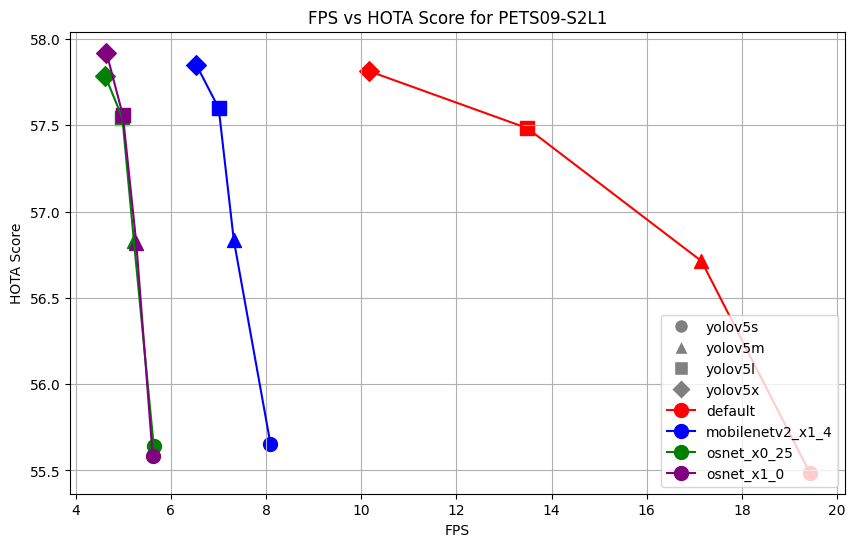

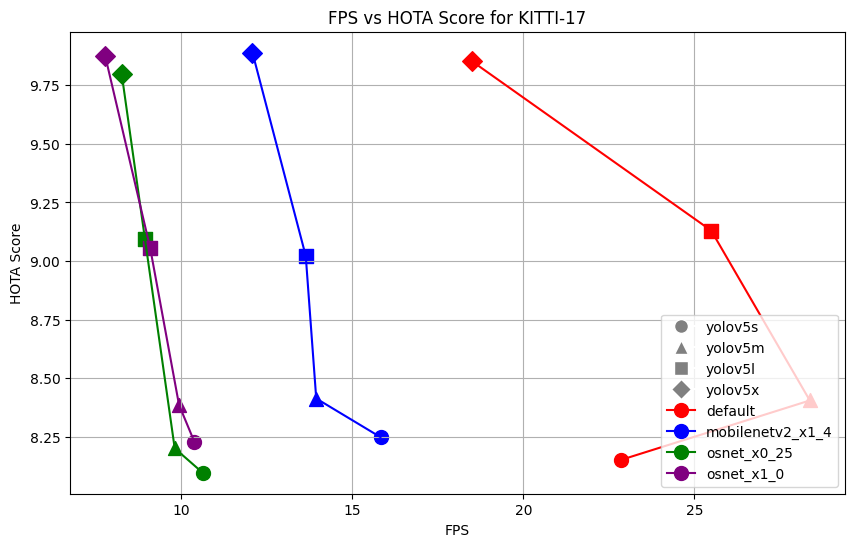

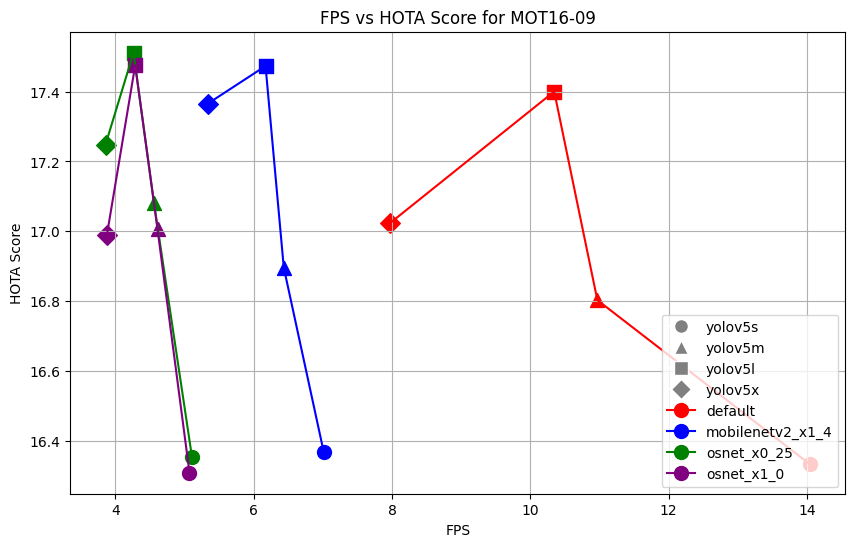

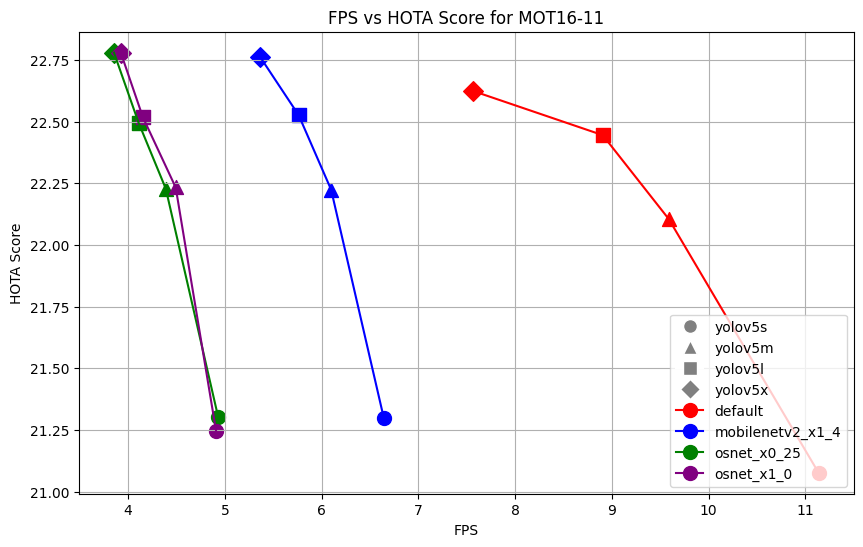

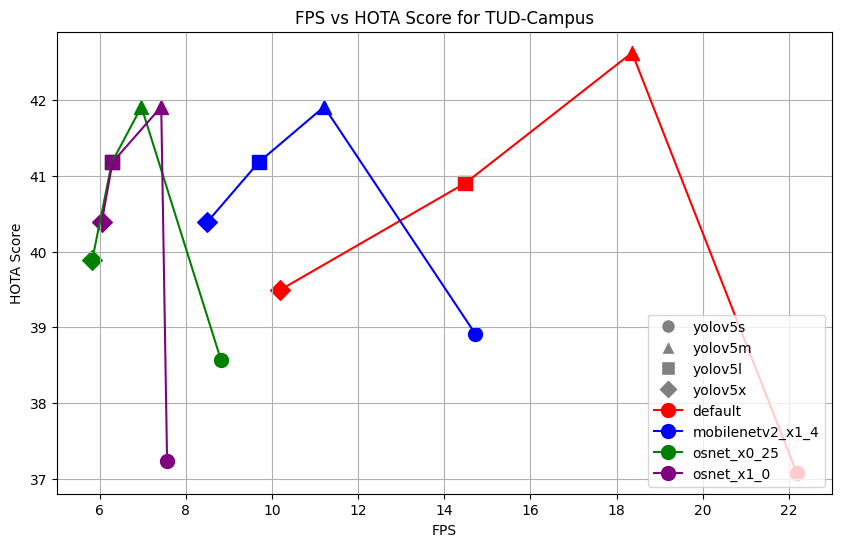

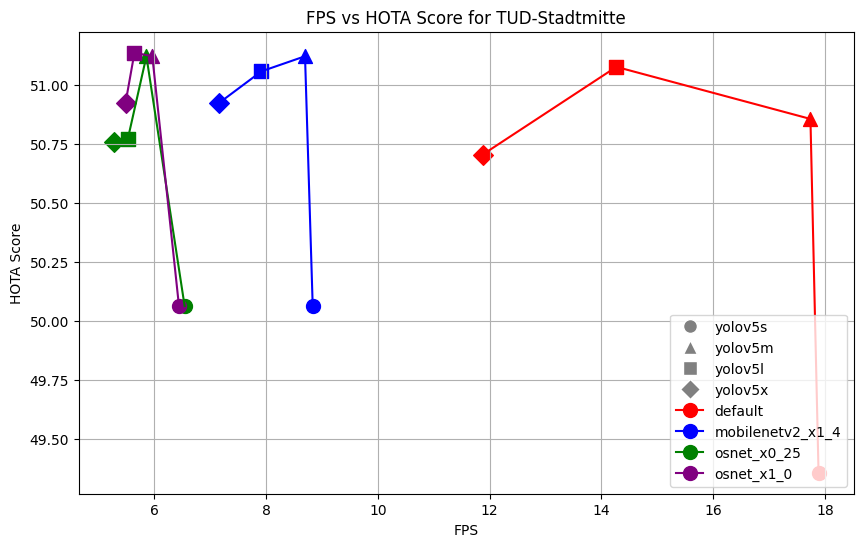

In [ ]:
import matplotlib.pyplot as plt
def plot_fps_vs_hota(data, title):
    model_colors = {'default': 'red', 'mobilenetv2_x1_4': 'blue', 'osnet_x0_25': 'green', 'osnet_x1_0': 'purple'}
    detector_markers = {'yolov5s': 'o', 'yolov5m': '^', 'yolov5l': 's', 'yolov5x': 'D'}
    plt.figure(figsize=(10, 6))

    for model in model_colors.keys():
        fps_values = []
        hota_scores = []
        for detector in detector_markers.keys():
            model_data = data[detector]['models'][model]
            fps_values.append(model_data['fps'])
            hota_scores.append(model_data['hota'])
            plt.scatter(model_data['fps'], model_data['hota'], color=model_colors[model], marker=detector_markers[detector], s=100)
           # plt.text(model_data['fps'] + 0.5, model_data['hota'] - 0.5, f'{detector}-{model}', fontsize=8)

        plt.plot(fps_values, hota_scores, color=model_colors[model])  # Plot the line for the model

    plt.xlabel('FPS')
    plt.ylabel('HOTA Score')
    plt.title(f'FPS vs HOTA Score for {title}')
    plt.grid(True)

    legend_elements = [plt.Line2D([0], [0], marker=detector_markers[detector], color='w', label=detector,
                                  markerfacecolor='gray', markersize=10) for detector in detector_markers.keys()] + \
                      [plt.Line2D([0], [0], marker='o', color=model_colors[model], label=model,
                                  markerfacecolor=model_colors[model], markersize=10) for model in model_colors.keys()]
    plt.legend(handles=legend_elements, loc="lower right")

    plt.show()


plot_fps_vs_hota(data0, "PETS09-S2L1")
plot_fps_vs_hota(data1, "KITTI-17")
plot_fps_vs_hota(data2, "MOT16-09")
plot_fps_vs_hota(data_mot16_11, "MOT16-11")
plot_fps_vs_hota(data_tud_campus, "TUD-Campus")
plot_fps_vs_hota(data_tud_stadtmitte, "TUD-Stadtmitte")



This code is executing a multiple-parameter evaluation for a YOLOv5 model and default reid across a range of tracking hyperparameters:

* It sets ranges of values for several parameters (confidence
threshold, IoU threshold, cosine distance, and NMS max overlap).
* Then, it iterates through every combination of these models and parameter values.
* For each combination, it runs an evaluation function (run_evaluation) and stores the results (FPS and HOTA scores) for each video.
* The results are stored in a dictionary (evaluation_results), which can later be used for analysis or visualization.

In [ ]:
import numpy as np
yolo_models = ['yolov5m',] #how to run colab with mobile internet...
reid_models = [
     ('mobilenetv2_x1_4', './reid_models/mobilenetv2_1.4-bc1cc36b.pth'),
]

conf_threshold_range = np.arange(0.25, 0.55, 0.05)
iou_threshold_range = np.arange(0.35, 0.6, 0.05)
#max_cosine_distance_range = np.arange(0.3, 0.4, 0.1)
#nms_max_overlap_range = np.arange(0.9, 1.0, 0.05)

evaluation_results = {}

for yolo_model in yolo_models:
    for reid_model_name, reid_model_path in reid_models:
        for conf_threshold in conf_threshold_range:
            for iou_threshold in iou_threshold_range:
              max_cosine_distance = 0.3
              nms_max_overlap = 1.0
              print(f"Evaluating combination: {yolo_model} - {reid_model_name}")
              print(f"Parameters: conf={conf_threshold}, iou={iou_threshold}, cosine={max_cosine_distance}, nms={nms_max_overlap}")
              results = run_evaluation(yolo_model, reid_model_name, reid_model_path, conf_threshold, iou_threshold, max_cosine_distance, nms_max_overlap)
              for result in results:
                  key = f"{yolo_model}_{reid_model_name}_conf{conf_threshold}_iou{iou_threshold}_cosine{max_cosine_distance}_nms{nms_max_overlap}_{result['video']}"
                  evaluation_results[key] = {"fps": result["fps"], "score": result["score"]}


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.25, iou=0.35, cosine=0.3, nms=1.0


100%|██████████| 40.8M/40.8M [00:00<00:00, 69.5MB/s]

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  6.721343220601538
HOTA 48.084


KITTI-17
FPS:  13.021751491227521
HOTA 9.2401


MOT16-09
FPS:  6.196443680621186
HOTA 16.073


MOT16-11
FPS:  6.10446835120543
HOTA 21.901


TUD-Campus
FPS:  10.400427059462652
HOTA 41.466


TUD-Stadtmitte
FPS:  8.669496589801284


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 51.95


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.25, iou=0.39999999999999997, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  6.844497745791861
HOTA 47.997


KITTI-17
FPS:  13.702885395938676
HOTA 9.0908


MOT16-09
FPS:  6.164140572562519
HOTA 15.944


MOT16-11
FPS:  5.994393242769188
HOTA 21.847


TUD-Campus
FPS:  9.129251579724226
HOTA 41.931


TUD-Stadtmitte
FPS:  9.121458707514146


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 52.099


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.25, iou=0.44999999999999996, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  6.70995183453241
HOTA 47.858


KITTI-17
FPS:  11.88658363424037
HOTA 8.9892


MOT16-09
FPS:  6.2329119145602725
HOTA 16.083


MOT16-11
FPS:  6.091506629992708
HOTA 21.85


TUD-Campus
FPS:  9.625264411841242
HOTA 41.688


TUD-Stadtmitte
FPS:  9.125482781686468


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 52.015


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.25, iou=0.49999999999999994, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.064842075952437
HOTA 47.163


KITTI-17
FPS:  12.88026799892972
HOTA 9.1838


MOT16-09
FPS:  6.220602115556537
HOTA 15.807


MOT16-11
FPS:  6.121079545908943
HOTA 21.665


TUD-Campus
FPS:  10.71265863639431
HOTA 42.781


TUD-Stadtmitte
FPS:  8.764701129612426


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA 51.591


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.25, iou=0.5499999999999999, cosine=0.3, nms=1.0


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  6.979866935038288
HOTA 46.594


KITTI-17
FPS:  12.420487824523581
HOTA 9.3778


MOT16-09
FPS:  5.993327381729344
HOTA 15.942


MOT16-11
FPS:  5.95895695767883
HOTA 21.385


TUD-Campus
FPS:  9.283212635232042
HOTA 42.35


TUD-Stadtmitte
FPS:  9.021752796852368


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 51.415


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.3, iou=0.35, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.109643514521282
HOTA 49.119


KITTI-17
FPS:  13.512064853032703
HOTA 9.1808


MOT16-09
FPS:  6.560934734501343
HOTA 16.125


MOT16-11
FPS:  6.253014084768814
HOTA 21.922


TUD-Campus
FPS:  9.950780464517207
HOTA 40.963


TUD-Stadtmitte
FPS:  9.481514050889325


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 52.013


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.3, iou=0.39999999999999997, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.126788157753793
HOTA 49.025


KITTI-17
FPS:  13.49575200771736
HOTA 9.0289


MOT16-09
FPS:  6.551335909004709
HOTA 16.39


MOT16-11
FPS:  6.227966993810977
HOTA 21.945


TUD-Campus
FPS:  11.893380532675591
HOTA 41.974


TUD-Stadtmitte
FPS:  8.687118352138867


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA 52.092


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.3, iou=0.44999999999999996, cosine=0.3, nms=1.0


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.105807389267517
HOTA 48.865


KITTI-17
FPS:  13.521150608693363
HOTA 8.8532


MOT16-09
FPS:  6.448989879525985
HOTA 16.432


MOT16-11
FPS:  6.163061383875782
HOTA 21.913


TUD-Campus
FPS:  11.40292888839706
HOTA 41.542


TUD-Stadtmitte
FPS:  8.814070572633687


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



HOTA 52.356


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.3, iou=0.49999999999999994, cosine=0.3, nms=1.0


Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  6.93937697342745
HOTA 48.205


KITTI-17
FPS:  13.133448215232573
HOTA 8.8841


MOT16-09
FPS:  6.213647849471498
HOTA 16.363


MOT16-11
FPS:  6.13386272361467
HOTA 21.792


TUD-Campus
FPS:  9.943058418604894
HOTA 42.638


TUD-Stadtmitte
FPS:  8.852962187856551


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 52.264


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.3, iou=0.5499999999999999, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  6.961355210939925
HOTA 47.536


KITTI-17
FPS:  13.584020794041967
HOTA 9.2435


MOT16-09
FPS:  6.2781775289626935
HOTA 16.168


MOT16-11
FPS:  6.061054274947401
HOTA 21.554


TUD-Campus
FPS:  9.533762457183471
HOTA 42.279


TUD-Stadtmitte
FPS:  9.375982796096402


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 51.711


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.35, iou=0.35, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.217480432826616
HOTA 49.52


KITTI-17
FPS:  13.746623604433337
HOTA 8.943


MOT16-09
FPS:  6.736987908774826
HOTA 16.381


MOT16-11
FPS:  6.310513646035801
HOTA 21.962


TUD-Campus
FPS:  12.448797249853532
HOTA 40.748


TUD-Stadtmitte
FPS:  8.940938203739144


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 51.932


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.35, iou=0.39999999999999997, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.305562319231395
HOTA 49.427


KITTI-17
FPS:  16.593882664462495
HOTA 8.7901


MOT16-09
FPS:  6.667542244577737
HOTA 16.437


MOT16-11
FPS:  6.38109413267958
HOTA 21.96


TUD-Campus
FPS:  11.978821869019173
HOTA 41.427


TUD-Stadtmitte
FPS:  8.969013507856317


YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 


HOTA 51.968


Evaluating combination: yolov5m - mobilenetv2_x1_4
Parameters: conf=0.35, iou=0.44999999999999996, cosine=0.3, nms=1.0


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
PETS09-S2L1
FPS:  7.215114902832912
HOTA 49.438


KITTI-17
FPS:  14.232586903510251
HOTA 8.6867


MOT16-09
FPS:  6.6767329246036375
HOTA 16.344


MOT16-11


KeyboardInterrupt: ignored

In [ ]:
print(evaluation_results)

{'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.721343220601538, 'score': 48.084}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_KITTI-17': {'fps': 13.021751491227521, 'score': 9.2401}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_MOT16-09': {'fps': 6.196443680621186, 'score': 16.073}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_MOT16-11': {'fps': 6.10446835120543, 'score': 21.901}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_TUD-Campus': {'fps': 10.400427059462652, 'score': 41.466}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.669496589801284, 'score': 51.95}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.844497745791861, 'score': 47.997}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_KITTI-17': {'fps': 13.702885395938676, 'score': 9.0908}, 'yolov5m_mobilenetv2_x1_4_

In [ ]:
best_scores = {}
for key, value in evaluation_results.items():
    video_name = key.split('_')[-1]
    if video_name in best_scores:
        if value["score"] > best_scores[video_name]["score"]:
            best_scores[video_name] = {"config": key, "score": value["score"], "fps": value["fps"]}
    else:
        best_scores[video_name] = {"config": key, "score": value["score"], "fps": value["fps"]}

for video_name, result in best_scores.items():
    print(f"Video: {video_name}")
    print(f"Best configuration: {result['config']}")
    print(f"Best score: {result['score']}")
    print(f"FPS: {result['fps']}")
    print("\n")


Video: PETS09-S2L1
Best configuration: yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_PETS09-S2L1
Best score: 49.52
FPS: 7.217480432826616


Video: KITTI-17
Best configuration: yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_KITTI-17
Best score: 9.3778
FPS: 12.420487824523581


Video: MOT16-09
Best configuration: yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-09
Best score: 16.437
FPS: 6.667542244577737


Video: MOT16-11
Best configuration: yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_MOT16-11
Best score: 21.962
FPS: 6.310513646035801


Video: TUD-Campus
Best configuration: yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_TUD-Campus
Best score: 42.781
FPS: 10.71265863639431


Video: TUD-Stadtmitte
Best configuration: yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_TUD-Stadtmitte
Best score: 52.356
FPS: 8.814070572633687




In [ ]:
#evaluation_results = {'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.721343220601538, 'score': 48.084}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_KITTI-17': {'fps': 13.021751491227521, 'score': 9.2401}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_MOT16-09': {'fps': 6.196443680621186, 'score': 16.073}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_MOT16-11': {'fps': 6.10446835120543, 'score': 21.901}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_TUD-Campus': {'fps': 10.400427059462652, 'score': 41.466}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.35_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.669496589801284, 'score': 51.95}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.844497745791861, 'score': 47.997}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_KITTI-17': {'fps': 13.702885395938676, 'score': 9.0908}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-09': {'fps': 6.164140572562519, 'score': 15.944}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-11': {'fps': 5.994393242769188, 'score': 21.847}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_TUD-Campus': {'fps': 9.129251579724226, 'score': 41.931}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.39999999999999997_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 9.121458707514146, 'score': 52.099}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.44999999999999996_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.70995183453241, 'score': 47.858}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.44999999999999996_cosine0.3_nms1.0_KITTI-17': {'fps': 11.88658363424037, 'score': 8.9892}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.44999999999999996_cosine0.3_nms1.0_MOT16-09': {'fps': 6.2329119145602725, 'score': 16.083}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.44999999999999996_cosine0.3_nms1.0_MOT16-11': {'fps': 6.091506629992708, 'score': 21.85}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.44999999999999996_cosine0.3_nms1.0_TUD-Campus': {'fps': 9.625264411841242, 'score': 41.688}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.44999999999999996_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 9.125482781686468, 'score': 52.015}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 7.064842075952437, 'score': 47.163}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_KITTI-17': {'fps': 12.88026799892972, 'score': 9.1838}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_MOT16-09': {'fps': 6.220602115556537, 'score': 15.807}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_MOT16-11': {'fps': 6.121079545908943, 'score': 21.665}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_TUD-Campus': {'fps': 10.71265863639431, 'score': 42.781}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.49999999999999994_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.764701129612426, 'score': 51.591}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.979866935038288, 'score': 46.594}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_KITTI-17': {'fps': 12.420487824523581, 'score': 9.3778}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_MOT16-09': {'fps': 5.993327381729344, 'score': 15.942}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_MOT16-11': {'fps': 5.95895695767883, 'score': 21.385}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_TUD-Campus': {'fps': 9.283212635232042, 'score': 42.35}, 'yolov5m_mobilenetv2_x1_4_conf0.25_iou0.5499999999999999_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 9.021752796852368, 'score': 51.415}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.35_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 7.109643514521282, 'score': 49.119}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.35_cosine0.3_nms1.0_KITTI-17': {'fps': 13.512064853032703, 'score': 9.1808}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.35_cosine0.3_nms1.0_MOT16-09': {'fps': 6.560934734501343, 'score': 16.125}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.35_cosine0.3_nms1.0_MOT16-11': {'fps': 6.253014084768814, 'score': 21.922}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.35_cosine0.3_nms1.0_TUD-Campus': {'fps': 9.950780464517207, 'score': 40.963}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.35_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 9.481514050889325, 'score': 52.013}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.39999999999999997_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 7.126788157753793, 'score': 49.025}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.39999999999999997_cosine0.3_nms1.0_KITTI-17': {'fps': 13.49575200771736, 'score': 9.0289}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-09': {'fps': 6.551335909004709, 'score': 16.39}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-11': {'fps': 6.227966993810977, 'score': 21.945}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.39999999999999997_cosine0.3_nms1.0_TUD-Campus': {'fps': 11.893380532675591, 'score': 41.974}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.39999999999999997_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.687118352138867, 'score': 52.092}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 7.105807389267517, 'score': 48.865}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_KITTI-17': {'fps': 13.521150608693363, 'score': 8.8532}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_MOT16-09': {'fps': 6.448989879525985, 'score': 16.432}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_MOT16-11': {'fps': 6.163061383875782, 'score': 21.913}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_TUD-Campus': {'fps': 11.40292888839706, 'score': 41.542}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.44999999999999996_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.814070572633687, 'score': 52.356}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.49999999999999994_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.93937697342745, 'score': 48.205}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.49999999999999994_cosine0.3_nms1.0_KITTI-17': {'fps': 13.133448215232573, 'score': 8.8841}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.49999999999999994_cosine0.3_nms1.0_MOT16-09': {'fps': 6.213647849471498, 'score': 16.363}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.49999999999999994_cosine0.3_nms1.0_MOT16-11': {'fps': 6.13386272361467, 'score': 21.792}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.49999999999999994_cosine0.3_nms1.0_TUD-Campus': {'fps': 9.943058418604894, 'score': 42.638}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.49999999999999994_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.852962187856551, 'score': 52.264}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.5499999999999999_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 6.961355210939925, 'score': 47.536}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.5499999999999999_cosine0.3_nms1.0_KITTI-17': {'fps': 13.584020794041967, 'score': 9.2435}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.5499999999999999_cosine0.3_nms1.0_MOT16-09': {'fps': 6.2781775289626935, 'score': 16.168}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.5499999999999999_cosine0.3_nms1.0_MOT16-11': {'fps': 6.061054274947401, 'score': 21.554}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.5499999999999999_cosine0.3_nms1.0_TUD-Campus': {'fps': 9.533762457183471, 'score': 42.279}, 'yolov5m_mobilenetv2_x1_4_conf0.3_iou0.5499999999999999_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 9.375982796096402, 'score': 51.711}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 7.217480432826616, 'score': 49.52}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_KITTI-17': {'fps': 13.746623604433337, 'score': 8.943}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_MOT16-09': {'fps': 6.736987908774826, 'score': 16.381}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_MOT16-11': {'fps': 6.310513646035801, 'score': 21.962}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_TUD-Campus': {'fps': 12.448797249853532, 'score': 40.748}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.35_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.940938203739144, 'score': 51.932}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_PETS09-S2L1': {'fps': 7.305562319231395, 'score': 49.427}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_KITTI-17': {'fps': 16.593882664462495, 'score': 8.7901}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-09': {'fps': 6.667542244577737, 'score': 16.437}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_MOT16-11': {'fps': 6.38109413267958, 'score': 21.96}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_TUD-Campus': {'fps': 11.978821869019173, 'score': 41.427}, 'yolov5m_mobilenetv2_x1_4_conf0.35_iou0.39999999999999997_cosine0.3_nms1.0_TUD-Stadtmitte': {'fps': 8.969013507856317, 'score': 51.968}}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to hold extracted data
iou_values = []
conf_values = []
fps_values = []
score_values = []

for key, value in evaluation_results.items():
    conf_values.append(float(key.split('_conf')[1].split('_iou')[0]))
    iou_values.append(float(key.split('_iou')[1].split('_cosine')[0]))
    fps_values.append(value['fps'])
    score_values.append(value['score'])

df = pd.DataFrame({
    'iou': iou_values,
    'conf': conf_values,
    'fps': fps_values,
    'score': score_values
})

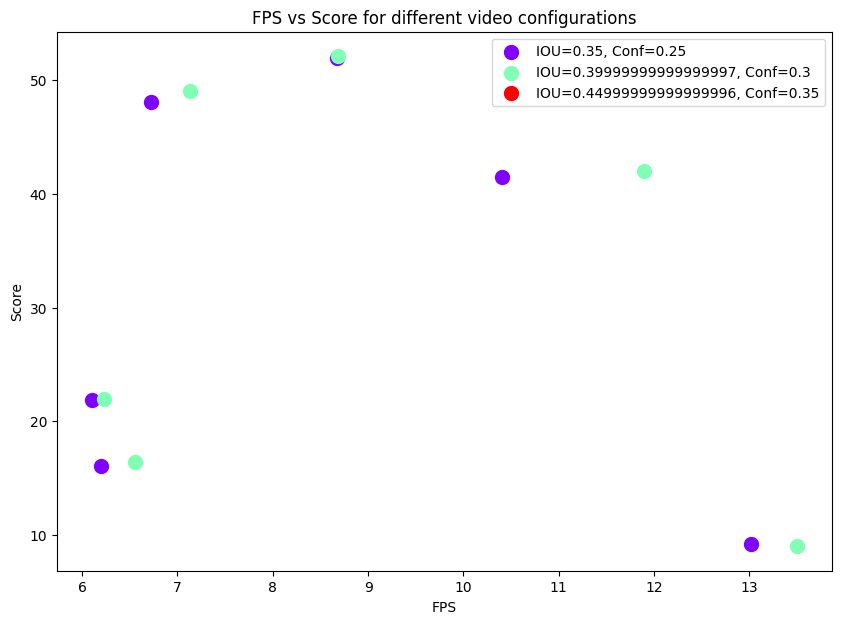

In [ ]:
configurations = list(zip(df['iou'].unique(), df['conf'].unique()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(configurations)))

plt.figure(figsize=(10, 7))
for config, color in zip(configurations, colors):
    subset_df = df[(df['iou'] == config[0]) & (df['conf'] == config[1])]
    plt.scatter(subset_df['fps'], subset_df['score'], color=color, s=100, label=f'IOU={config[0]}, Conf={config[1]}')

plt.xlabel('FPS')
plt.ylabel('Score')
plt.legend()
plt.title('FPS vs Score for different video configurations')
plt.show()


In [ ]:
# Just wonder how it actually runs with normal report and all. FPS should be around 6.
device = select_device('0' if torch.cuda.is_available() else 'cpu')
mds = ModifiedDeepSort(
        device= device,
        detector_weights='./detector/yolov5l.pt',
        conf_threshold = 0.45,
        iou_threshold = 0.4,
        max_cosine_distance = 0.3,
        nms_max_overlap = 1.0,
        encoder_model_name = 'mobilenetv2_x1_4',
        encoder_model_path = './reid_models/mobilenetv2_1.4-bc1cc36b.pth',
    )

video_file_path = Path(f"./sample/PETS09-S2L1-raw.webm")

_, tracker_results, fps = mds.get_detections_and_track2(video_file_path, sort=True, save_result=True)
path = f'TrackEval/data/trackers/mot_challenge/MOT15-train/NEWTrack/data'
filename = os.path.join(path, f'PETS09-S2L1.txt')
np.savetxt(filename, tracker_results, delimiter=',', fmt='%i')
!python TrackEval/scripts/run_mot_challenge.py --SEQ_INFO PETS09-S2L1 --BENCHMARK MOT15 --TRACKERS_TO_EVAL NEWTrack --METRICS HOTA  --USE_PARALLEL False --NUM_PARALLEL_CORES 1

YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424
Successfully loaded pretrained weights from "./reid_models/mobilenetv2_1.4-bc1cc36b.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.1.weight', 'classifier.1.bias']
FPS:  6.743280256569827

Eval Config:
USE_PARALLEL         : False                         
NUM_PARALLEL_CORES   : 1                             
BREAK_ON_ERROR       : True                          
RETURN_ON_ERROR      : False                         
LOG_ON_ERROR         : /content/deep_sort/TrackEval/error_log.txt
PRINT_RESULTS        : True                          
PRINT_ONLY_COMBINED  : False                         
PRINT_CONFIG         : True                          
TIME_PROGRESS        : True                          
DISPLAY_LESS_PROGRESS : False                         
OUTPUT_SUMMARY       : True                          
OUTPUT_EMPTY_CLASSES : True                          
OUTPUT_DETAILED      : True